In [287]:
import pandas as pd
import datetime as dt
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, shapiro

In [288]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)


1.4.2
1.22.3
0.11.2


In [289]:
def read_weather_excel(file_path):
    weather_names = ['date', 'temp_max', 'temp_min', 'temp_avg', 'temp_departure', 
                     'HDD', 'CDD', 'precipitation', 'new_snow', 'snow_depth']
    weather_list = []

    for i in range(12):
        weather = pd.read_excel(file_path, skiprows=3, header=None, names=weather_names, sheet_name=i)
        weather_list.append(weather)
    weather_df = pd.concat(weather_list, axis=0)
    weather_df = weather_df[~weather_df['date'].isin(['Sum', 'Average', 'Normal'])]
    return weather_df

In [290]:
weather_18 = read_weather_excel('./Weather 2018-NYC.xlsx')
weather_19 = read_weather_excel('./Weather 2019-NYC.xlsx')
weather = pd.concat([weather_18, weather_19], axis=0)
weather['date'] = pd.to_datetime(weather['date'])

In [291]:
weather.head()

,date,temp_max,temp_min,temp_avg,temp_departure,HDD,CDD,precipitation,new_snow,snow_depth
0,2018-01-01,19.0,7.0,13,-22.2,52,0,0,0,T
1,2018-01-02,26.0,13.0,19.5,-15.5,45,0,0,0,0
2,2018-01-03,30.0,16.0,23,-11.8,42,0,0,0,T
3,2018-01-04,29.0,19.0,24,-10.7,41,0,0.76,9.8,1
4,2018-01-05,19.0,9.0,14,-20.5,51,0,0,0,7


In [292]:
demand = pd.read_excel('./ColumbiaDemand.xlsx', header=0, usecols=[0, 1], names=['date', 'demand'])
demand['date'] = pd.to_datetime(demand['date'])

In [293]:
demand

,date,demand
0,2018-01-01,72686.88
1,2018-01-02,73594.08
2,2018-01-03,73440.00
3,2018-01-04,73967.04
4,2018-01-05,74625.12
...,...,...
725,2019-12-27,81070.56
726,2019-12-28,79395.84
727,2019-12-29,75379.68
728,2019-12-30,76459.68


In [294]:
data = pd.merge(demand, weather, how='left', on='date')

In [295]:
data = data.replace('T', 0)
sub_col = ['demand', 'temp_min', 'temp_max', 'temp_avg', 'temp_departure', 'HDD', 'CDD', 'precipitation', 'new_snow', 'snow_depth']
data.loc[:, sub_col] = data.loc[:, sub_col].astype('float32')

data = data.fillna(0)
assert data.isnull().sum().sum() == 0
data = data.set_index(data.date).loc[:, data.columns[1:]]
data = data.add(-data.mean(axis=0)).div(data.std(axis=0))
data.head()


,demand,temp_max,temp_min,temp_avg,temp_departure,HDD,CDD,precipitation,new_snow,snow_depth
date,,,,,,,,,,
2018-01-01,-0.420324,-2.383882,-2.462359,-2.446059,-3.036963,2.933816,-0.63958,-0.450433,-0.120433,-0.161001
2018-01-02,-0.342370,-2.001593,-2.110708,-2.074857,-2.118787,2.412363,-0.63958,-0.450433,-0.120433,-0.161001
2018-01-03,-0.355610,-1.783142,-1.934883,-1.874979,-1.611735,2.188882,-0.63958,-0.450433,-0.120433,-0.161001
2018-01-04,-0.310322,-1.837755,-1.759058,-1.817871,-1.460990,2.114389,-0.63958,1.657007,15.210177,1.255034
2018-01-05,-0.253775,-2.383882,-2.345143,-2.388951,-2.803993,2.859323,-0.63958,-0.450433,-0.120433,9.751243


### Optional: merge with calendar info

In [296]:
calendar = pd.read_excel('./calendar.xlsx')
calendar['dayoff'] = (calendar['holiday'] | calendar['weekend'])
cal_data = pd.concat([calendar.loc[:, ['date', 'class', 'dayoff']],
                      pd.get_dummies(calendar.day_of_the_week)], axis=1)
cal_data = cal_data.set_index(calendar.date).loc[:, cal_data.columns[1:]]
cal_data.head()

,class,dayoff,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wedesday,Wednesday
date,,,,,,,,,,
2018-01-01,0,0,0,1,0,0,0,0,0,0
2018-01-02,0,0,0,0,0,0,0,1,0,0
2018-01-03,0,0,0,0,0,0,0,0,1,0
2018-01-04,0,0,0,0,0,0,1,0,0,0
2018-01-05,0,0,1,0,0,0,0,0,0,0


In [297]:
data = pd.merge(data, cal_data, how='inner', on='date')

In [298]:
data.head()

,demand,temp_max,temp_min,temp_avg,temp_departure,HDD,CDD,precipitation,new_snow,snow_depth,class,dayoff,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wedesday,Wednesday
date,,,,,,,,,,,,,,,,,,,,
2018-01-01,-0.420324,-2.383882,-2.462359,-2.446059,-3.036963,2.933816,-0.63958,-0.450433,-0.120433,-0.161001,0,0,0,1,0,0,0,0,0,0
2018-01-02,-0.342370,-2.001593,-2.110708,-2.074857,-2.118787,2.412363,-0.63958,-0.450433,-0.120433,-0.161001,0,0,0,0,0,0,0,1,0,0
2018-01-03,-0.355610,-1.783142,-1.934883,-1.874979,-1.611735,2.188882,-0.63958,-0.450433,-0.120433,-0.161001,0,0,0,0,0,0,0,0,1,0
2018-01-04,-0.310322,-1.837755,-1.759058,-1.817871,-1.460990,2.114389,-0.63958,1.657007,15.210177,1.255034,0,0,0,0,0,0,1,0,0,0
2018-01-05,-0.253775,-2.383882,-2.345143,-2.388951,-2.803993,2.859323,-0.63958,-0.450433,-0.120433,9.751243,0,0,1,0,0,0,0,0,0,0


In [299]:
data.columns

Index(['demand', 'temp_max', 'temp_min', 'temp_avg', 'temp_departure', 'HDD',
       'CDD', 'precipitation', 'new_snow', 'snow_depth', 'class', 'dayoff',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wedesday', 'Wednesday'],
      dtype='object')

### Energy Demand

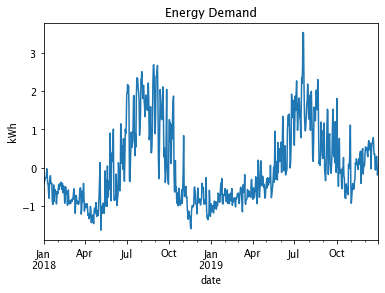

In [300]:
data.demand.plot(title="Energy Demand")
plt.ylabel("kWh")
plt.show()

### Clean Up

In [301]:
data = data.replace('T', 0)
sub_col = ['demand', 'temp_max', 'temp_avg', 'temp_departure', 'HDD', 'CDD', 'precipitation', 'new_snow', 'snow_depth']
data.loc[:, sub_col] = data.loc[:, sub_col].astype('float32')

data = data.fillna(0)
assert data.isnull().sum().sum() == 0
data[sub_col] = data[sub_col].add(-data[sub_col].mean(axis=0)).div(data[sub_col].std(axis=0))
data.head()

,demand,temp_max,temp_min,temp_avg,temp_departure,HDD,CDD,precipitation,new_snow,snow_depth,class,dayoff,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wedesday,Wednesday
date,,,,,,,,,,,,,,,,,,,,
2018-01-01,-0.420324,-2.383882,-2.462359,-2.446059,-3.036963,2.933816,-0.63958,-0.450433,-0.120433,-0.161001,0,0,0,1,0,0,0,0,0,0
2018-01-02,-0.342371,-2.001593,-2.110708,-2.074857,-2.118787,2.412363,-0.63958,-0.450433,-0.120433,-0.161001,0,0,0,0,0,0,0,1,0,0
2018-01-03,-0.355610,-1.783142,-1.934883,-1.874979,-1.611735,2.188882,-0.63958,-0.450433,-0.120433,-0.161001,0,0,0,0,0,0,0,0,1,0
2018-01-04,-0.310323,-1.837755,-1.759058,-1.817872,-1.460990,2.114389,-0.63958,1.657007,15.210177,1.255034,0,0,0,0,0,0,1,0,0,0
2018-01-05,-0.253775,-2.383882,-2.345143,-2.388951,-2.803993,2.859323,-0.63958,-0.450433,-0.120433,9.751243,0,0,1,0,0,0,0,0,0,0


EDA: Exploratory Data Analysis
* Target Analysis
* Seasonality and Trend

### Target Analyisis

In [302]:
mean = np.mean(data.demand.values)
std = np.std(data.demand.values)
skew_ = skew(data.demand.values)
ex_kurt_ = kurtosis(data.demand)
print(f'Skewness: {skew_} \nKurtosis: {ex_kurt_ + 3}')

Skewness: 0.8996179644559983 
Kurtosis: 2.9403044933358395


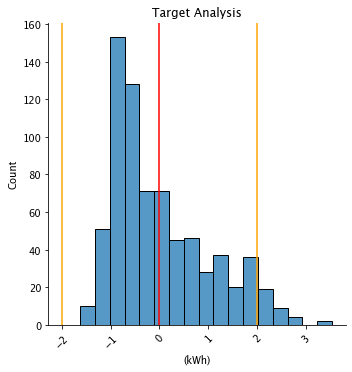

In [303]:
sns.displot(data.demand)
plt.title("Target Analysis")
plt.xticks(rotation=45)
plt.xlabel("(kWh)")
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()

### Volatility Analysis


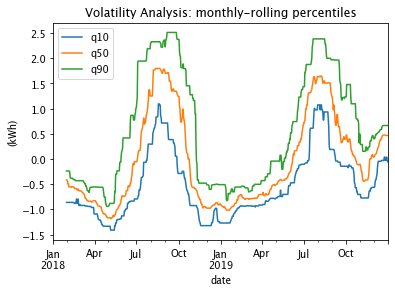

In [304]:
data_rolling = data.demand.rolling(window=30)
data['q10'] = data_rolling.quantile(0.1).to_frame("q10")
data['q50'] = data_rolling.quantile(0.5).to_frame("q50")
data['q90'] = data_rolling.quantile(0.9).to_frame("q90")

data[["q10", "q50", "q90"]].plot(title="Volatility Analysis: monthly-rolling percentiles")
plt.ylabel("(kWh)")
plt.show()

### Time Series Analysis: Seasonality and Trend

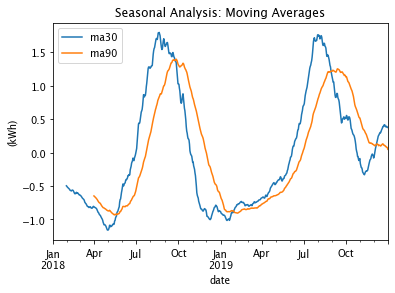

In [305]:
data['ma30'] = data.demand.rolling(30).mean()
data['ma90'] = data.demand.rolling(90).mean()
data[["ma30", "ma90"]].plot(title="Seasonal Analysis: Moving Averages")
plt.ylabel("(kWh)")
plt.show()

### Split Data

In [355]:
features = ['temp_max', 'temp_min', 'temp_avg', 'temp_departure', 'HDD',
       'CDD', 'precipitation', 'new_snow', 'snow_depth', 'class', 'dayoff',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wedesday', 'Wednesday']

target = 'demand'
n = int(data.shape[0] * 0.75)
x_train = data[features][:n]
y_train = data[target][:n].values.ravel()

x_test = data[features][n:]
y_test = data[target][n:].values.ravel()

k = x_train.shape[1]
print("Total number of observations: ", data.shape[0])
print("Train: {}{}, \nTest: {}{}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

Total number of observations:  730
Train: (547, 19)(547,), 
Test: (183, 19)(183,)


In [356]:
data.columns


Index(['demand', 'temp_max', 'temp_min', 'temp_avg', 'temp_departure', 'HDD',
       'CDD', 'precipitation', 'new_snow', 'snow_depth', 'class', 'dayoff',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wedesday', 'Wednesday', 'q10', 'q50', 'q90', 'ma30', 'ma90'],
      dtype='object')

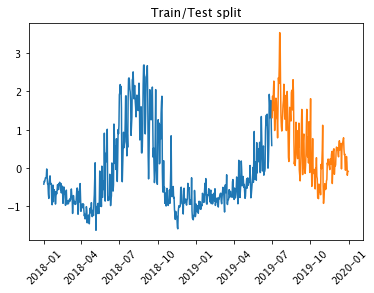

In [357]:
plt.plot(x_train.index, y_train, label="train")
plt.plot(x_test.index, y_test, label="test")
plt.title("Train/Test split")
plt.xticks(rotation=45)
plt.show()

### Model 1: Linear Regression

In [358]:
x_train.isnull().sum().sum()


0

In [359]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(x_train, y_train)
p_train_lr = reg.predict(x_train)
p_test_lr = reg.predict(x_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train_lr))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test_lr))

print(f'Train RMSE: {RMSE_train}\nTest RMSE: {RMSE_test}')


Train RMSE: 0.4446709928373968
Test RMSE: 0.6625564830045476


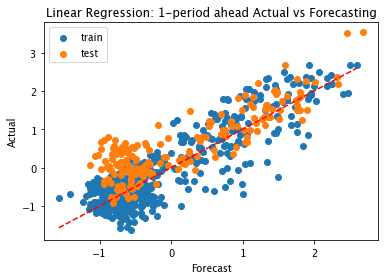

In [360]:
plt.scatter(y=y_train, x=p_train_lr, label='train')
plt.scatter(y=y_test, x=p_test_lr, label='test')
plt.plot([p_train_lr.min(), p_train_lr.max()], [p_train_lr.min(), p_train_lr.max()], '--r')
plt.title('Linear Regression: 1-period ahead Actual vs Forecasting')
plt.ylabel('Actual')
plt.xlabel('Forecast')
plt.legend()
plt.show()

### Model 2: Random Forest Regressor

In [361]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=400, max_depth=5, random_state=10086).fit(x_train, y_train)
p_train_rfr = rfr.predict(x_train)
p_test_rfr = rfr.predict(x_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train_rfr))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test_rfr))

print(f'Train RMSE: {RMSE_train}\nTest RMSE: {RMSE_test}')


Train RMSE: 0.2771630884483108
Test RMSE: 0.7171222063380555


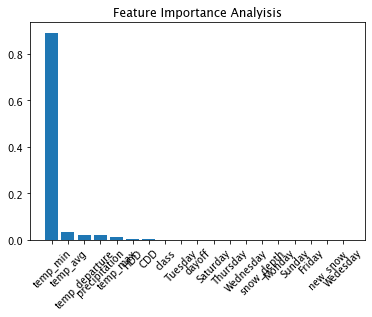

In [362]:
importances = rfr.feature_importances_

sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:20]
x = range(len(sorted_index_top))

labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature Importance Analyisis")
plt.xticks(rotation=45)
plt.show()

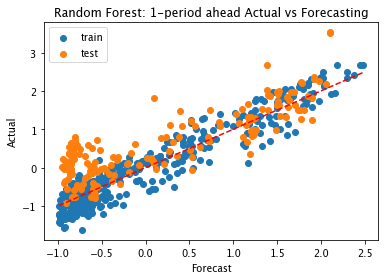

In [363]:
plt.scatter(y=y_train, x=p_train_rfr, label='train')
plt.scatter(y=y_test, x=p_test_rfr, label='test')
plt.plot([p_train_rfr.min(), p_train_rfr.max()], [p_train_rfr.min(), p_train_rfr.max()], '--r')

plt.title('Random Forest: 1-period ahead Actual vs Forecasting')
plt.ylabel('Actual')
plt.xlabel('Forecast')
plt.legend()
plt.show()

### Model 3: Multi-layer Perceptron regressor

In [364]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(5, 3), solver='lbfgs', max_iter=10000, random_state=10086).fit(x_train, y_train)
p_train_mlp = mlp.predict(x_train)
p_test_mlp = mlp.predict(x_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train_mlp))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test_mlp))

print(f'Train RMSE: {RMSE_train}\nTest RMSE: {RMSE_test}')


Train RMSE: 0.2928840200082186
Test RMSE: 0.7619812231503591


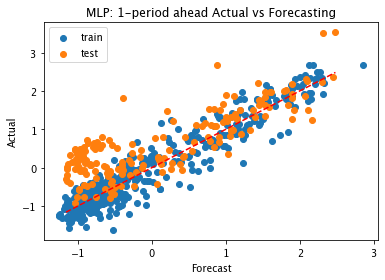

In [365]:
plt.scatter(y=y_train, x=p_train_mlp, label='train')
plt.scatter(y=y_test, x=p_test_mlp, label='test')
plt.plot([p_test_mlp.min(), p_test_mlp.max()], [p_test_mlp.min(), p_test_mlp.max()], '--r')

plt.title('MLP: 1-period ahead Actual vs Forecasting')
plt.ylabel('Actual')
plt.xlabel('Forecast')
plt.legend()
plt.show()

In [366]:
from sklearn.metrics import r2_score

print(f'R^2 score of Linear Regression model: {r2_score(y_test, p_test_lr)}')
print(f'R^2 score of Random Forest model: {r2_score(y_test, p_test_rfr)}')
print(f'R^2 score of MLP model: {r2_score(y_test, p_test_mlp)}')

R^2 score of Linear Regression model: 0.3933650697833798
R^2 score of Random Forest model: 0.2893300699802286
R^2 score of MLP model: 0.19763839787706927
